In [1]:
# imports

import csv
import json
import os
import re
from pprint import pprint

import gensim
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import PyPDF2
import spacy
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

# set seed for reproducibility
# np.random.seed(493)


nltk.download("stopwords")
nltk.download("wordnet")
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

ps = nltk.porter.PorterStemmer()

import re
import unicodedata

import openai
from gsdmm import MovieGroupProcess

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
stop_words = stopwords.words("english")

import time

from nltk.sentiment.vader import SentimentIntensityAnalyzer

/opt/conda/lib/python3.10/site-packages/PyPDF2/__init__.py:21: DeprecationWarning: PyPDF2 is deprecated. Please move to the pypdf library instead.
  warnings.warn(
2023-02-25 03:55:20.870011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 03:55:21.679196: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-25 03:55:21.679330: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

## Functions for Text Cleaning and Topic Modeling

In [2]:
def tokeniz(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))


# function to filter out stopwords
def remove_stopwords(texts):
    return [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts
    ]


# function for lemmatization
def lemmatize(texts, allowed_postags=["NOUN", "ADJ", "VERB"]):
    texts_op = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_op.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        )
    return texts_op


from copy import deepcopy


def top_words(cluster_word_distribution, top_cluster, values):
    words = []
    for cluster in top_cluster:
        sort_dicts = sorted(
            cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True
        )[:values]
        words.append([w[0] for w in sort_dicts])
        # print('Cluster %s : %s'%(cluster,sort_dicts))
        # print('-'*120)
    words1 = deepcopy(words)
    for i in range(len(words)):
        for j in range(len(words[i])):
            for k in range(len(words)):
                if k != i and words[i][j] in words[k]:
                    try:
                        words1[i].remove(words[i][j])
                        words1[k].remove(words[i][j])
                    except:
                        pass
    return words1


def create_topics_dataframe(data_text, mgp, threshold, topic_dict, stem_text):
    result = pd.DataFrame(columns=["text", "topic", "stems"])
    for i, text in enumerate(data_text):
        result.at[i, "text"] = text
        result.at[i, "stems"] = stem_text[i]
        prob = mgp.choose_best_label(stem_text[i])
        if prob[1] >= threshold:
            result.at[i, "topic"] = topic_dict[prob[0]]
        else:
            result.at[i, "topic"] = "Other"
    return result

In [3]:
import os
import sys
from contextlib import contextmanager


@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [4]:
# Building Bigram & Trigram Models
# bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[processed_data], threshold=100)
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)


# function to filter out stopwords
def remove_stopwords(texts):
    return [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts
    ]


# function to create bigrams
def create_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


# function to create trigrams
def create_trigrams(texts):
    [trigram_mod[bigram_mod[doc]] for doc in texts]


# function for lemmatization
def lemmatize(texts, allowed_postags=["NOUN", "ADJ", "VERB"]):
    texts_op = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_op.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        )
    return texts_op

In [5]:
nltk.download([
...     "names",
...     "stopwords",
...     "state_union",
...     "twitter_samples",
...     "movie_reviews",
...     "averaged_perceptron_tagger",
...     "vader_lexicon",
...     "punkt",
... ])

[nltk_data] Downloading package names to /home/jovyan/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Packag

True

## Organizing Transcript-Topics
Final data saves with transcript, topic keywords, sentiment, and program

In [40]:
tr_tp_st = [[], [], [], []]

gl = pd.read_csv("foxGuestList.csv", encoding="windows-1252")
fox = open("fox_text.txt", "r", encoding="windows-1252")
fox = fox.readlines()
for l in range(len(fox)):
    #######################################
    ##Turning transcript into df of lines##
    #######################################
    lines = pd.DataFrame(
        columns=["Date", "Start_Hour", "Program", "Title", "Speaker", "Line"]
    )
    # print(lines)
    transcript = fox[l]
    meta = gl.iloc[l, :]
    dt = meta["Date"]
    if "January" in str(dt):
        print(l)
        chunks = transcript.split("|")
        line = ""
        spkr = ""
        for c in chunks:
            if (
                "Page" not in c[0:10]
                and "...." not in c
                and c[0:15] not in meta["Title"]
            ):
                # print(c)
                if ":" in c:
                    c = c.split(":")
                    if str.isupper(c[0]):
                        lines.loc[len(lines)] = [
                            meta["Date"],
                            meta["Start_Hour"],
                            meta["Program"],
                            meta["Title"],
                            spkr,
                            line,
                        ]
                        # print(spkr + ':' + line)
                        spkr = c[0]
                        line = c[1]
                else:
                    line += c
        lines.loc[len(lines)] = [
            meta["Date"],
            meta["Start_Hour"],
            meta["Program"],
            meta["Title"],
            spkr,
            line,
        ]

        # cleaning Speaker
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.strip())
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.split(","))
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x[0])
        speakers = []
        spkr_list = lines["Speaker"].unique()
        for s in lines["Speaker"]:
            s1 = s.split(" ")
            if len(s1) == 1:
                for s2 in spkr_list:
                    if s1[0] in s2:
                        speakers.append(s2)
                        break
            else:
                speakers.append(s)
        lines["Speaker"] = speakers
        # lines.to_csv('fox_lines_test.csv')
        data = lines["Line"]

        # cleaning text
        processed_data = list(tokeniz(data))

        ####################################
        ##cleaning text for topic modeling##
        ####################################
        # Building Bigram & Trigram Models
        bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)
        bigram_mod = gensim.models.phrases.Phraser(bigram)

        # function to filter out stopwords
        def remove_stopwords(texts):
            return [
                [word for word in simple_preprocess(str(doc)) if word not in stop_words]
                for doc in texts
            ]

        # function to create bigrams
        def create_bigrams(texts):
            return [bigram_mod[doc] for doc in texts]

        # removing stopwords, creating bigrams and lemmatizing the text
        data_wo_stopwords = remove_stopwords(processed_data)
        data_bigrams = create_bigrams(data_wo_stopwords)
        data_lemmatized = lemmatize(
            data_bigrams, allowed_postags=["NOUN", "ADJ", "VERB"]
        )

        ######################
        #####TOPIC MODELING###
        ######################

        texts = data_lemmatized
        mgp = MovieGroupProcess(K=5, alpha=0.1, beta=0.1, n_iters=30)

        vocab = set(x for doc in texts for x in doc)
        n_terms = len(vocab)
        with suppress_stdout():
            y = mgp.fit(texts, n_terms)
        doc_count = np.array(mgp.cluster_doc_count)
        top_index = doc_count.argsort()[-10:][::-1]
        tw = top_words(mgp.cluster_word_distribution, top_index, 15)

        topic_dict = {}

        for i, topic_num in enumerate(top_index):
            topic_dict[topic_num] = i

        dfx = create_topics_dataframe(
            data_text=lines["Line"],
            mgp=mgp,
            threshold=0.3,
            topic_dict=topic_dict,
            stem_text=texts,
        )

        transcript = pd.merge(lines, dfx, left_on="Line", right_on="text")

        ######################
        ##Sentiment Analysis##
        ######################
        transcript["stems_str"] = transcript["stems"].apply(lambda x: " ".join(x))
        sid = SentimentIntensityAnalyzer()
        transcript["VADER"] = transcript["Line"].apply(
            lambda x: list(sid.polarity_scores(x).values())[3]
        )

        ######################
        ##Storing Each Topic##
        ######################
        for t in range(len(transcript["topic"].unique())):
            df = transcript[transcript["topic"] == t]

            if len(df) > 2:
                tr_tp_st[0].append(l)
                tr_tp_st[1].append(tw[t])
                tr_tp_st[2].append(df["VADER"].mean())
                tr_tp_st[3].append(lines["Program"][0])


gl = pd.read_csv("msnbcGuestList.csv", encoding="windows-1252")
fox = open("msnbc_text.txt", "r", encoding="windows-1252")
fox = fox.readlines()
for l in range(len(fox)):
    #######################################
    ##Turning transcript into df of lines##
    #######################################
    lines = pd.DataFrame(
        columns=["Date", "Start_Hour", "Program", "Title", "Speaker", "Line"]
    )
    # print(lines)
    transcript = fox[l]
    meta = gl.iloc[l, :]
    dt = meta["Date"]
    if "January" in str(dt):
        print(l)
        chunks = transcript.split("|")
        line = ""
        spkr = ""
        for c in chunks:
            if (
                "Page" not in c[0:10]
                and "...." not in c
                and c[0:15] not in meta["Title"]
            ):
                # print(c)
                if ":" in c:
                    c = c.split(":")
                    if str.isupper(c[0]):
                        lines.loc[len(lines)] = [
                            meta["Date"],
                            meta["Start_Hour"],
                            meta["Program"],
                            meta["Title"],
                            spkr,
                            line,
                        ]
                        # print(spkr + ':' + line)
                        spkr = c[0]
                        line = c[1]
                else:
                    line += c
        lines.loc[len(lines)] = [
            meta["Date"],
            meta["Start_Hour"],
            meta["Program"],
            meta["Title"],
            spkr,
            line,
        ]

        # cleaning Speaker
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.strip())
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.split(","))
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x[0])
        speakers = []
        spkr_list = lines["Speaker"].unique()
        for s in lines["Speaker"]:
            s1 = s.split(" ")
            if len(s1) == 1:
                for s2 in spkr_list:
                    if s1[0] in s2:
                        speakers.append(s2)
                        break
            else:
                speakers.append(s)
        lines["Speaker"] = speakers
        # lines.to_csv('fox_lines_test.csv')
        data = lines["Line"]

        # cleaning text
        processed_data = list(tokeniz(data))

        ####################################
        ##cleaning text for topic modeling##
        ####################################
        # Building Bigram & Trigram Models
        bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)
        bigram_mod = gensim.models.phrases.Phraser(bigram)

        # function to filter out stopwords
        def remove_stopwords(texts):
            return [
                [word for word in simple_preprocess(str(doc)) if word not in stop_words]
                for doc in texts
            ]

        # function to create bigrams
        def create_bigrams(texts):
            return [bigram_mod[doc] for doc in texts]

        # removing stopwords, creating bigrams and lemmatizing the text
        data_wo_stopwords = remove_stopwords(processed_data)
        data_bigrams = create_bigrams(data_wo_stopwords)
        data_lemmatized = lemmatize(
            data_bigrams, allowed_postags=["NOUN", "ADJ", "VERB"]
        )

        ######################
        #####TOPIC MODELING###
        ######################

        texts = data_lemmatized
        mgp = MovieGroupProcess(K=5, alpha=0.1, beta=0.1, n_iters=30)

        vocab = set(x for doc in texts for x in doc)
        n_terms = len(vocab)
        with suppress_stdout():
            y = mgp.fit(texts, n_terms)
        doc_count = np.array(mgp.cluster_doc_count)
        top_index = doc_count.argsort()[-10:][::-1]
        tw = top_words(mgp.cluster_word_distribution, top_index, 15)

        topic_dict = {}

        for i, topic_num in enumerate(top_index):
            topic_dict[topic_num] = i

        dfx = create_topics_dataframe(
            data_text=lines["Line"],
            mgp=mgp,
            threshold=0.3,
            topic_dict=topic_dict,
            stem_text=texts,
        )

        transcript = pd.merge(lines, dfx, left_on="Line", right_on="text")

        ######################
        ##Sentiment Analysis##
        ######################
        transcript["stems_str"] = transcript["stems"].apply(lambda x: " ".join(x))
        sid = SentimentIntensityAnalyzer()
        transcript["VADER"] = transcript["Line"].apply(
            lambda x: list(sid.polarity_scores(x).values())[3]
        )

        ######################
        ##Storing Each Topic##
        ######################
        for t in range(len(transcript["topic"].unique())):
            df = transcript[transcript["topic"] == t]

            if len(df) > 2:
                tr_tp_st[0].append(l + 2000)
                tr_tp_st[1].append(tw[t])
                tr_tp_st[2].append(df["VADER"].mean())
                tr_tp_st[3].append(lines["Program"][0])

gl = pd.read_csv("CNNGuestList.csv", encoding="windows-1252")
fox = open("cnn_text.txt", "r", encoding="windows-1252")
fox = fox.readlines()
for l in range(len(fox)):
    #######################################
    ##Turning transcript into df of lines##
    #######################################
    lines = pd.DataFrame(
        columns=["Date", "Start_Hour", "Program", "Title", "Speaker", "Line"]
    )
    # print(lines)
    transcript = fox[l]
    meta = gl.iloc[l, :]
    dt = meta["Date"]
    if "January" in str(dt):
        print(l)
        chunks = transcript.split("|")
        line = ""
        spkr = ""
        for c in chunks:
            if (
                "Page" not in c[0:10]
                and "...." not in c
                and c[0:15] not in meta["Title"]
            ):
                # print(c)
                if ":" in c:
                    c = c.split(":")
                    if str.isupper(c[0]):
                        lines.loc[len(lines)] = [
                            meta["Date"],
                            meta["Start_Hour"],
                            meta["Program"],
                            meta["Title"],
                            spkr,
                            line,
                        ]
                        # print(spkr + ':' + line)
                        spkr = c[0]
                        line = c[1]
                else:
                    line += c
        lines.loc[len(lines)] = [
            meta["Date"],
            meta["Start_Hour"],
            meta["Program"],
            meta["Title"],
            spkr,
            line,
        ]

        # cleaning Speaker
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.strip())
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.split(","))
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x[0])
        speakers = []
        spkr_list = lines["Speaker"].unique()
        for s in lines["Speaker"]:
            s1 = s.split(" ")
            if len(s1) == 1:
                for s2 in spkr_list:
                    if s1[0] in s2:
                        speakers.append(s2)
                        break
            else:
                speakers.append(s)
        lines["Speaker"] = speakers
        # lines.to_csv('fox_lines_test.csv')
        data = lines["Line"]

        # cleaning text
        processed_data = list(tokeniz(data))

        ####################################
        ##cleaning text for topic modeling##
        ####################################
        # Building Bigram & Trigram Models
        bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)
        bigram_mod = gensim.models.phrases.Phraser(bigram)

        # function to filter out stopwords
        def remove_stopwords(texts):
            return [
                [word for word in simple_preprocess(str(doc)) if word not in stop_words]
                for doc in texts
            ]

        # function to create bigrams
        def create_bigrams(texts):
            return [bigram_mod[doc] for doc in texts]

        # removing stopwords, creating bigrams and lemmatizing the text
        data_wo_stopwords = remove_stopwords(processed_data)
        data_bigrams = create_bigrams(data_wo_stopwords)
        data_lemmatized = lemmatize(
            data_bigrams, allowed_postags=["NOUN", "ADJ", "VERB"]
        )

        ######################
        #####TOPIC MODELING###
        ######################

        texts = data_lemmatized
        mgp = MovieGroupProcess(K=5, alpha=0.1, beta=0.1, n_iters=30)

        vocab = set(x for doc in texts for x in doc)
        n_terms = len(vocab)
        with suppress_stdout():
            y = mgp.fit(texts, n_terms)
        doc_count = np.array(mgp.cluster_doc_count)
        top_index = doc_count.argsort()[-10:][::-1]
        tw = top_words(mgp.cluster_word_distribution, top_index, 15)

        topic_dict = {}

        for i, topic_num in enumerate(top_index):
            topic_dict[topic_num] = i

        dfx = create_topics_dataframe(
            data_text=lines["Line"],
            mgp=mgp,
            threshold=0.3,
            topic_dict=topic_dict,
            stem_text=texts,
        )

        transcript = pd.merge(lines, dfx, left_on="Line", right_on="text")

        ######################
        ##Sentiment Analysis##
        ######################
        transcript["stems_str"] = transcript["stems"].apply(lambda x: " ".join(x))
        sid = SentimentIntensityAnalyzer()
        transcript["VADER"] = transcript["Line"].apply(
            lambda x: list(sid.polarity_scores(x).values())[3]
        )

        ######################
        ##Storing Each Topic##
        ######################
        for t in range(len(transcript["topic"].unique())):
            df = transcript[transcript["topic"] == t]

            if len(df) > 2:
                tr_tp_st[0].append(l)
                tr_tp_st[1].append(tw[t])
                tr_tp_st[2].append(df["VADER"].mean())
                tr_tp_st[3].append(lines["Program"][0])


21
36
38
48
53
85
86
90
91
105
115
141
146
168
243
251
270
284
332
338
344
401
407
441
442
459
461
470
473
475
490
491
496
497
501
505
508
511
513
514
520
537
546
584
600
601
646
648
656
699
706
740
741
742
750
790
811
832
833
856
857
859
860
861
862
863
864
869
870
871
873
887
891
892
893
894
895
921
923
986
1058
1083
1090
1098
1099
1102
1107
1116
1123
1174
1223
1227
1228
1254
1279
1286
1294
1295
1300
1308
1309
1310
1311
1312
1313
1314
1319
1401
1409
1426
1445
1482
1525
1530
1531
1536
1564
1565
1597
1599
1611
1612
1617
1628
1638
1644
1703
1715
1716
1717
1798
1859
1871
1881
1883
1897
1906
1919
1959
1982
1983
1996
2001
2009
2017
2025
2043
2044
2055
2059
2071
2074
2079
2096
2097
2103
2128
2148
2159
2160
2171
2184
2185
2186
2189
2194
2195
2230
2238
2244
2245
2248
2263
2269
2271
2273
2283
2293
2302
2303
2306
2307
2312
2325
2326
2327
2328
2362
2374
2400
2406
2434
2451
2457
2469
2470
2473
2474
2485
2495
2503
2504
2507
2508
2509
2510
2511
2512
2513
2539
2572
2582
2584
2586
2607
2616
2628
2633

IndexError: single positional indexer is out-of-bounds

In [7]:
print(tr_tp_st[0][:5])
print(tr_tp_st[1][:5])
print(tr_tp_st[2][:5])
print(tr_tp_st[3][:5])
print(len(tr_tp_st[1]))
print(tr_tp_st[3][1440])

[21, 21, 21, 21, 21]
[['know', 'stage', 'vote', 'evidence', 'grief', 'mueller'], ['word', 'impeachment', 'see', 'election', 'free'], ['generation', 'question', 'come', 'good', 'egg'], ['memo', 'information', 'comey', 'medium', 'month', 'course', 'leak', 'send', 'write', 'page'], ['report', 'tonight', 'liberal', 'angle', 'kid']]
[0.06882647058823531, 0.13064848484848487, -0.09138709677419356, -0.21464285714285714, -0.1739]
['Fox News Network INGRAHAM ANGLE', 'Fox News Network INGRAHAM ANGLE', 'Fox News Network INGRAHAM ANGLE', 'Fox News Network INGRAHAM ANGLE', 'Fox News Network INGRAHAM ANGLE']
1864
MSNBC 11TH HOUR WITH BRIAN WILLIAMS


## Calculating Similarities Between Topics

In [8]:
def jaccard_similarity(x, y):
    """returns the jaccard similarity between two lists"""
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality / float(union_cardinality)

In [41]:
# turning transcript-topics into a dataframe and adding an id var
tdf = pd.DataFrame(
    zip(tr_tp_st[0], tr_tp_st[1], tr_tp_st[2], tr_tp_st[3]),
    columns=["Transcript", "Topic", "Sentiment", "Program"],
)
id = []
for i in range(len(tr_tp_st[0])):
    try:
        id.append(str(tr_tp_st[0][i]) + tr_tp_st[1][i][0])
    except:
        print("oops " + str(tr_tp_st[0][i]))
        id.append(str(tr_tp_st[0][i]))
tdf["id"] = id

oops 7138


In [10]:
tdf.head()

,Transcript,Topic,Sentiment,Program,id
0,21,"[know, stage, vote, evidence, grief, mueller]",0.068826,Fox News Network INGRAHAM ANGLE,21know
1,21,"[word, impeachment, see, election, free]",0.130648,Fox News Network INGRAHAM ANGLE,21word
2,21,"[generation, question, come, good, egg]",-0.091387,Fox News Network INGRAHAM ANGLE,21generation
3,21,"[memo, information, comey, medium, month, cour...",-0.214643,Fox News Network INGRAHAM ANGLE,21memo
4,21,"[report, tonight, liberal, angle, kid]",-0.173900,Fox News Network INGRAHAM ANGLE,21report


In [11]:
tdf["Sentiment"].describe()

count    1864.000000
mean        0.130005
std         0.211628
min        -0.902333
25%         0.007771
50%         0.146215
75%         0.267228
max         0.911409
Name: Sentiment, dtype: float64

In [16]:
def jaccard_similarity(z):
  """ returns the jaccard similarity between two lists """
  x = z[0]
  y = z[1]
  if len(x) > 0 and len(y) > 0:
    x = x.split(',')
    #print(x)
    y = y.split(',')
    #y = y.replace('[','').replace(']','').split(',')
    #x = set(x)
    #y = set(y)
    #print(y)
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    #intersection = len(tuple(x.intersection(y)))
    #union = (len(x) + len(y)) - intersection
    #return float(intersection) / union
    return intersection_cardinality/float(union_cardinality)
  else:
    print('ah')
    return 0

In [42]:
from itertools import combinations
 

topicdf = tdf
#combodf
 
# size of combination is set to 3
a = list(combinations(topicdf['id'], 2))
y = [' '.join(i) for i in a]
#len(y)
a = pd.DataFrame(a, columns = ['id1','id2'])
b = a.merge(tdf, how='left', left_on = 'id1', right_on = 'id')
c = b.merge(tdf, how='left', left_on = 'id2', right_on = 'id', suffixes = ("1","2"))
c = c.iloc[:,[0,2,3,4,5,1,7,8,9,10]]
c["topic1"] = [','.join(map(str, l)) for l in c['Topic1']]
c["topic2"] = [','.join(map(str, l)) for l in c['Topic2']]
c['topics'] = c["topic1"] + ';' + c["topic2"]
print(c["topic1"])
c['score'] = c['topics'].apply(lambda x: jaccard_similarity(x.split(";")))
c['diff'] = abs(c['Sentiment1'] - c['Sentiment2'])
c[2040:2045]

/tmp/ipykernel_2582/3656822501.py:13: FutureWarning: Passing 'suffixes' which cause duplicate columns {'id1'} in the result is deprecated and will raise a MergeError in a future version.
  c = b.merge(tdf, how='left', left_on = 'id2', right_on = 'id', suffixes = ("1","2"))


0                          word,impeachment,election,evidence
1                          word,impeachment,election,evidence
2                          word,impeachment,election,evidence
3                          word,impeachment,election,evidence
4                          word,impeachment,election,evidence
                                  ...                        
21875786    week,start,couple,senator,trial,police,thank,c...
21875787    week,start,couple,senator,trial,police,thank,c...
21875788                     voter,look,state,black,important
21875789                     voter,look,state,black,important
21875790    threat,concern,capital,community,peaceful,offi...
Name: topic1, Length: 21875791, dtype: object
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah
ah

,id1,Transcript1,Topic1,Sentiment1,Program1,id2,Transcript2,Topic2,Sentiment2,Program2,topic1,topic2,topics,score,diff
2040,21word,21,"[word, impeachment, election, evidence]",-0.031867,Fox News Network INGRAHAM ANGLE,572case,572,"[case, day, spread, continue, worker, least, v...",0.072708,CNN CNN NEWSROOM,"word,impeachment,election,evidence","case,day,spread,continue,worker,least,virus,tr...","word,impeachment,election,evidence;case,day,sp...",0.000000,0.104575
2041,21word,21,"[word, impeachment, election, evidence]",-0.031867,Fox News Network INGRAHAM ANGLE,572helicopter,572,"[helicopter, crash, daughter, former, kill, gi...",-0.018550,CNN CNN NEWSROOM,"word,impeachment,election,evidence","helicopter,crash,daughter,former,kill,gianna,l...","word,impeachment,election,evidence;helicopter,...",0.000000,0.013317
2042,21word,21,"[word, impeachment, election, evidence]",-0.031867,Fox News Network INGRAHAM ANGLE,572president_trump,572,"[president_trump, ambassador, security, make, ...",0.554183,CNN CNN NEWSROOM,"word,impeachment,election,evidence","president_trump,ambassador,security,make,impea...","word,impeachment,election,evidence;president_t...",0.071429,0.586051
2043,21word,21,"[word, impeachment, election, evidence]",-0.031867,Fox News Network INGRAHAM ANGLE,595bryant,595,"[bryant, begin, crash, helicopter, thank, peac...",-0.043740,CNN CNN NEWSROOM,"word,impeachment,election,evidence","bryant,begin,crash,helicopter,thank,peace,spea...","word,impeachment,election,evidence;bryant,begi...",0.000000,0.011873
2044,21word,21,"[word, impeachment, election, evidence]",-0.031867,Fox News Network INGRAHAM ANGLE,595witness,595,"[witness, trial, call, side, president, impeac...",0.256193,CNN CNN NEWSROOM,"word,impeachment,election,evidence","witness,trial,call,side,president,impeachment,...","word,impeachment,election,evidence;witness,tri...",0.083333,0.288060


'MSNBC'

In [13]:
# creating simmilarity scores between each transcript combo
topicdf = tdf
scoredf = pd.DataFrame(columns=["id1",  "id2", "score"])
for j in range(len(topicdf)):
    print(j)
    x = topicdf["Topic"][j]
    # print(x)
    for i in range(j + 1, len(topicdf)):
        y = topicdf["Topic"][i]
        try:
            s = jaccard_similarity(x, y)
        except:
            s = 0
        scoredf.loc[len(scoredf.index)] = [
            topicdf["id"][j],
            topicdf["id"][i],
            s,
        ]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Grouping by Program for Program Similarity and Sentiment Difference Scores

In [ ]:
print(topicdf["Program"].unique())

In [22]:
print(c.columns)

Index(['id1', 'Transcript1', 'Topic1', 'Sentiment1', 'Program1', 'id2',
       'Transcript2', 'Topic2', 'Sentiment2', 'Program2', 'topic1', 'topic2',
       'topics', 'score', 'diff'],
      dtype='object')


In [68]:
print(len(sdf))
print(len(tr_tp_st[0]))
sdf.head()


4642580
6601


,id1,Transcript1,Topic1,Sentiment1,Program1,id2,Transcript2,Topic2,Sentiment2,Program2,topic1,topic2,topics,score,diff
6,21word,21,"[word, impeachment, election, evidence]",-0.031867,Fox News Network INGRAHAM ANGLE,36question,36,"[question, point, whistleblower, fact, senator...",0.133683,Fox News Network INGRAHAM ANGLE,"word,impeachment,election,evidence","question,point,whistleblower,fact,senator,evid...","word,impeachment,election,evidence;question,po...",0.090909,0.165550
8,21word,21,"[word, impeachment, election, evidence]",-0.031867,Fox News Network INGRAHAM ANGLE,36court,36,"[court, impeachment, conversation, time, polit...",-0.074050,Fox News Network INGRAHAM ANGLE,"word,impeachment,election,evidence","court,impeachment,conversation,time,political,...","word,impeachment,election,evidence;court,impea...",0.071429,0.042183
26,21word,21,"[word, impeachment, election, evidence]",-0.031867,Fox News Network INGRAHAM ANGLE,85come,85,"[come, move, impeachment, send, article, respo...",0.036283,Fox News Network LIVE EVENT,"word,impeachment,election,evidence","come,move,impeachment,send,article,respond,wit...","word,impeachment,election,evidence;come,move,i...",0.062500,0.068151
32,21word,21,"[word, impeachment, election, evidence]",-0.031867,Fox News Network INGRAHAM ANGLE,86place,86,"[place, troop, question, kill, militia, defend...",-0.613333,Fox News Network LIVE EVENT,"word,impeachment,election,evidence","place,troop,question,kill,militia,defend,immin...","word,impeachment,election,evidence;place,troop...",0.083333,0.581466
39,21word,21,"[word, impeachment, election, evidence]",-0.031867,Fox News Network INGRAHAM ANGLE,91thank,91,"[thank, impeachment, end, vote, want, way, talk]",0.255020,Fox News Network TUCKER CARLSON TONIGHT,"word,impeachment,election,evidence","thank,impeachment,end,vote,want,way,talk","word,impeachment,election,evidence;thank,impea...",0.100000,0.286887


In [43]:
# making a program df
#sdf = scoredf[scoredf["score"] > 0]
sdf = c[c["score"] > 0]
#sdf["diff"] = abs(sdf["s1"] - sdf["s2"])
#sdf["adj_diff"] = abs(sdf["s1"] - sdf["s2"]) * sdf["score"]
progdf = pd.DataFrame(columns=["pr1", "pr2", "distance", "score"])
for pr1 in topicdf["Program"].unique():
    print(pr1)
    for pr2 in topicdf["Program"].unique():
        pdf = sdf.loc[
            ((sdf["Program1"] == pr1) | (sdf["Program2"] == pr1))
            & ((sdf["Program1"] == pr2) | (sdf["Program2"] == pr2))
        ]
        pdf2 = c.loc[
            ((c["Program1"] == pr1) | (c["Program2"] == pr1))
            & ((c["Program1"] == pr2) | (c["Program2"] == pr2))
        ]
        if len(pdf) > 0 and pr1 != pr2:
            # diff_score is the weighted average of sentiment difference with topic simmilarity as the weight
            diff_score = np.average(pdf["diff"], weights=pdf["score"])

            # topic simm score is the average difference between topics discussed (the sum of topic simmilarity values divided by the count of topic combinations)
            topic_simm_score = pdf["score"].sum() / pdf2["score"].count()

            progdf.loc[len(progdf.index)] = [pr1, pr2, diff_score, topic_simm_score]

Fox News Network INGRAHAM ANGLE
Fox News Network FOX SPECIAL REPORT WITH BRET BAIER
Fox News Network THE FIVE
Fox News Network LIVE EVENT
Fox News Network TUCKER CARLSON TONIGHT
Fox News Network LIFE LIBERTY LEVIN
Fox News Network YOUR WORLD WITH NEIL CAVUTO
Fox News Network WATTERS WORLD
Fox News Network THE GREG GUTFELD SHOW
Fox News Network FOX NEWS SUNDAY
Fox News Network FOX HANNITY
Fox News Network MEDIA BUZZ
Fox News Network THE STORY WITH MARTHA MACCALLUM
Fox News Network FOX AND FRIENDS
Fox News Network FOX NEWS @ NIGHT
Fox News Network THE NEXT REVOLUTION
Fox News Network JUSTICE WITH JUDGE PIRRO
Fox News Network SUNDAY MORNING FUTURES
MSNBC POLITICS NATION
MSNBC ALL IN with CHRIS HAYES
MSNBC ANDREA MITCHELL REPORTS
MSNBC HARDBALL
MSNBC MSNBC LIVE
MSNBC MTP DAILY
MSNBC 11TH HOUR WITH BRIAN WILLIAMS
MSNBC THE BEAT WITH ARI MELBER
MSNBC MSNBC SPECIAL
MSNBC THE RACHEL MADDOW SHOW
MSNBC THE LAST WORD WITH LAWRENCE O`DONNELL
CNN ERIN BURNETT OUTFRONT
CNN EARLY START
CNN New Day
CN

In [44]:
sdf["score"].describe()

count    4.642580e+06
mean     7.155222e-02
std      3.280271e-02
min      3.448276e-02
25%      5.263158e-02
50%      6.250000e-02
75%      7.692308e-02
max      1.000000e+00
Name: score, dtype: float64

In [45]:
progdf.to_csv("program_scores_january.csv")

In [46]:
print(sdf["diff"].describe())
print(progdf["distance"].describe())
print(progdf["score"].describe())

count    4.642580e+06
mean     2.527466e-01
std      2.043216e-01
min      0.000000e+00
25%      9.524220e-02
50%      2.044334e-01
75%      3.598020e-01
max      1.812600e+00
Name: diff, dtype: float64
count    2550.000000
mean        0.233585
std         0.039484
min         0.112904
25%         0.204841
50%         0.226976
75%         0.260292
max         0.509903
Name: distance, dtype: float64
count    2550.000000
mean        0.015048
std         0.002437
min         0.005381
25%         0.013324
50%         0.015240
75%         0.016690
max         0.031643
Name: score, dtype: float64


In [47]:
scoredf.head()

,id1,id2,score
0,21know,21word,0.000000
1,21know,21generation,0.000000
2,21know,21memo,0.000000
3,21know,21report,0.000000
4,21know,36witness,0.090909


## Visualizations

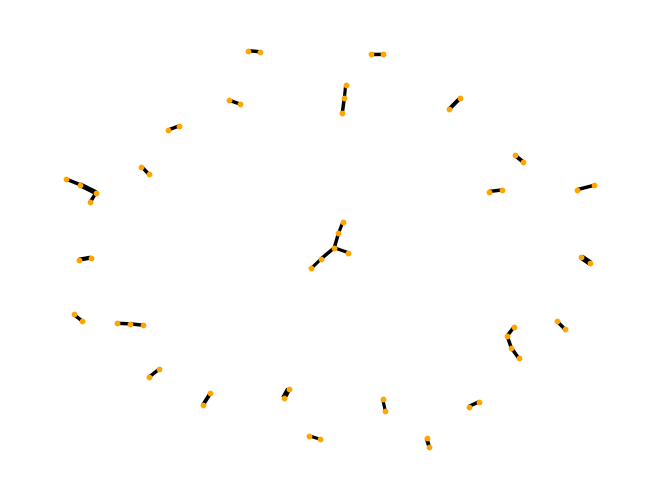

In [60]:
# attempt to plot simmilarities between topics, ended up being really bad
G = nx.from_pandas_edgelist(
    scoredf[scoredf["score"] > 0.45], "id1", "id2", edge_attr="score"
)

# Plot the network:
nx.draw(
    G,
    with_labels=False,
    node_color="orange",
    node_size=10,
    edge_color="black",
    linewidths=1,
    width=scoredf[scoredf["score"] > 0.45]["score"] * 5,
)

In [ ]:
progdf["score"].describe()

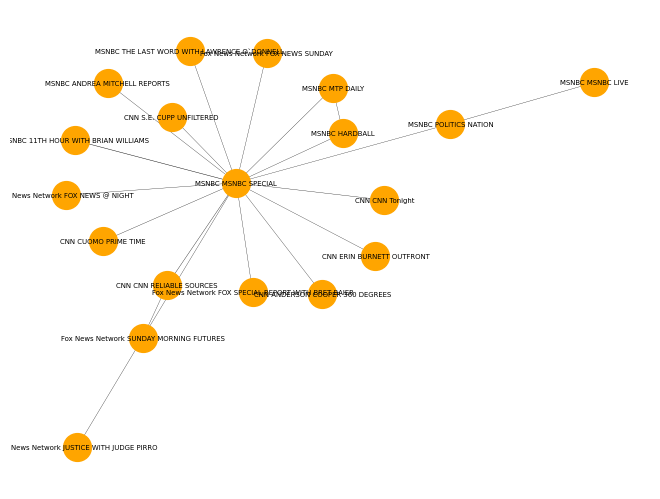

In [65]:
import networkx as nx

G = nx.from_pandas_edgelist(
    progdf[progdf["score"] > 0.020], "pr1", "pr2", edge_attr="score"
)

# Plot the network:
nx.draw(
    G,
    with_labels=True,
    node_color="orange",
    node_size=400,
    edge_color="black",
    linewidths=1,
    font_size=5,
    width=progdf[progdf["score"] > 0.020]["score"] * 10,
)

In [49]:
# converting to wide
progwd = progdf.pivot(index="pr1", columns="pr2", values="distance").fillna(0)
print(progwd["MSNBC MSNBC LIVE"])

progwd2 = progdf.pivot(index="pr1", columns="pr2", values="score").fillna(0)
print(progwd2["MSNBC MSNBC LIVE"])

pr1
CNN ANDERSON COOPER 360 DEGREES                        0.324844
CNN AT THIS HOUR                                       0.333965
CNN CNN 10                                             0.301968
CNN CNN LIVE EVENT/SPECIAL                             0.258008
CNN CNN NEWSROOM                                       0.320074
CNN CNN RELIABLE SOURCES                               0.282633
CNN CNN RIGHT NOW                                      0.338389
CNN CNN Special Reports                                0.391560
CNN CNN Tonight                                        0.283933
CNN CUOMO PRIME TIME                                   0.263274
CNN EARLY START                                        0.348073
CNN ERIN BURNETT OUTFRONT                              0.295756
CNN FAREED ZAKARIA GPS                                 0.346590
CNN Inside Politics                                    0.283995
CNN New Day                                            0.279983
CNN New Day Saturday                

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit(progwd).transform(progwd), columns = ['pca1','pca2'])
pca_df['Program'] = progwd.index
pca_df['Channel'] = pca_df['Program'].apply(lambda x: 'Fox' if 'Fox' in x else ('MSNBC' if 'MSNBC' in x else 'CNN'))
pca_df['Program'] = pca_df['Program'].apply(lambda x: x.replace('Fox News Network ',''))
pca_df['Program'] = pca_df['Program'].apply(lambda x: x.replace('CNN ',''))
pca_df['Program'] = pca_df['Program'].apply(lambda x: x.replace('MSNBC ',''))
print(pca_df)

pca = PCA(n_components=2)
pca_df2 = pd.DataFrame(pca.fit(progwd2).transform(progwd2), columns = ['pca1','pca2'])
pca_df2['Program'] = progwd2.index
pca_df2['Channel'] = pca_df2['Program'].apply(lambda x: 'Fox' if 'Fox' in x else ('MSNBC' if 'MSNBC' in x else 'CNN'))
pca_df2['Program'] = pca_df2['Program'].apply(lambda x: x.replace('Fox News Network ',''))
pca_df2['Program'] = pca_df2['Program'].apply(lambda x: x.replace('CNN ',''))
pca_df2['Program'] = pca_df['Program'].apply(lambda x: x.replace('MSNBC ',''))
print(pca_df2)

        pca1      pca2                                Program Channel
0  -0.147281  0.032609            ANDERSON COOPER 360 DEGREES     CNN
1   0.220213  0.070548                           AT THIS HOUR     CNN
2   0.467398  0.128204                                     10     CNN
3   0.012179 -0.087420                     LIVE EVENT/SPECIAL     CNN
4   0.141219  0.110786                               NEWSROOM     CNN
5  -0.156174  0.023511                       RELIABLE SOURCES     CNN
6   0.329001  0.182426                              RIGHT NOW     CNN
7  -0.200265  0.072219                        Special Reports     CNN
8  -0.075761 -0.044935                                Tonight     CNN
9  -0.139024 -0.030108                       CUOMO PRIME TIME     CNN
10  0.142345  0.150024                            EARLY START     CNN
11 -0.078211 -0.003097                  ERIN BURNETT OUTFRONT     CNN
12  0.176368  0.227883                     FAREED ZAKARIA GPS     CNN
13  0.366808  0.0256

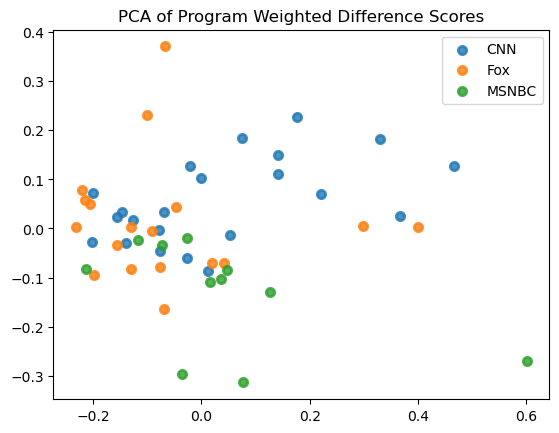

In [51]:
#weighted network of programs
plt.figure()
lw = 2

for c in pca_df['Channel'].unique():
    plt.scatter(
        pca_df[pca_df["Channel"] == c]["pca1"], pca_df[pca_df["Channel"] == c]["pca2"],  alpha=0.8, lw=lw, label=c
    )
"""for i in pca_df.index:
    if pca_df["Channel"][i] == "CNN" and (pca_df["pca1"][i] - pca_df["pca2"][i]) > 0.2:
        plt.text(x=pca_df.pca1[i]+0.01,y=pca_df.pca2[i]+0.01,s=pca_df.Program[i], 
            fontdict=dict(color='red',size=10),
            bbox=dict(facecolor='yellow',alpha=0.5))
    if pca_df["Channel"][i] == "Fox" and (pca_df["pca1"][i] - pca_df["pca2"][i]) < -0.095:
        plt.text(x=pca_df.pca1[i]+0.01,y=pca_df.pca2[i]+0.01,s=pca_df.Program[i], 
            fontdict=dict(color='red',size=10),
            bbox=dict(facecolor='yellow',alpha=0.5))"""
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of Program Weighted Difference Scores")



plt.show()

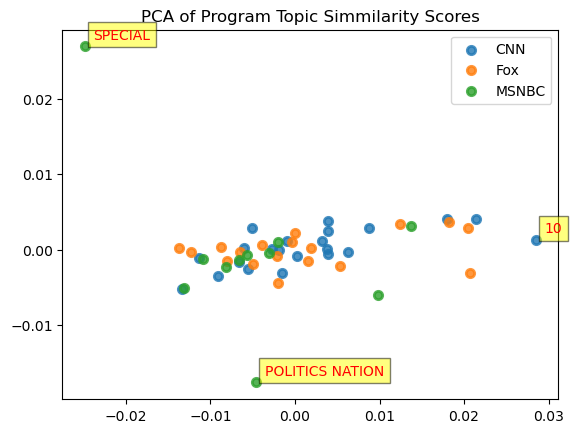

In [67]:
plt.figure()
lw = 2

for c in pca_df2["Channel"].unique():
    plt.scatter(
        pca_df2[pca_df2["Channel"] == c]["pca1"],
        pca_df2[pca_df2["Channel"] == c]["pca2"],
        alpha=0.8,
        lw=lw,
        label=c,
    )
for i in pca_df.index:
    if pca_df2.pca1[i] > 0.024 or pca_df2.pca2[i] < -0.01 or pca_df2.pca2[i] > 0.02:
        plt.text(
            x=pca_df2.pca1[i] + 0.001,
            y=pca_df2.pca2[i] + 0.001,
            s=pca_df2.Program[i],
            fontdict=dict(color="red", size=10),
            bbox=dict(facecolor="yellow", alpha=0.5),
        )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of Program Topic Simmilarity Scores")


plt.show()